In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Analitical Solution | Infinite Potencial Well


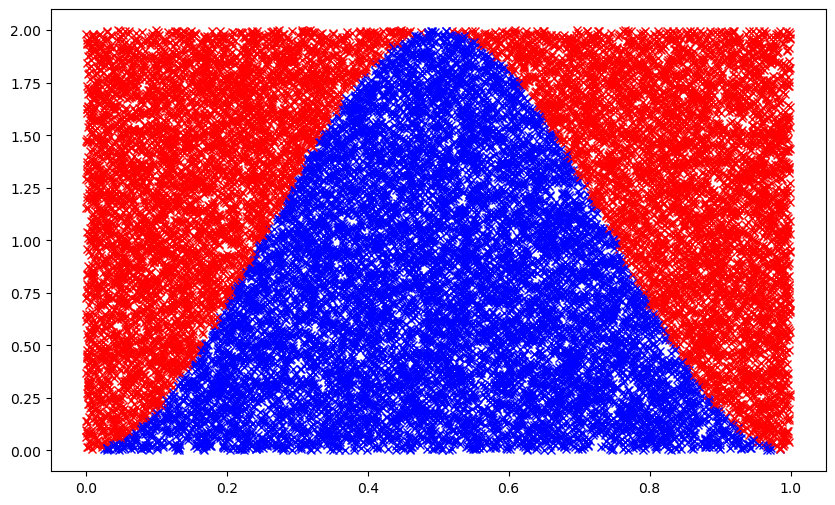

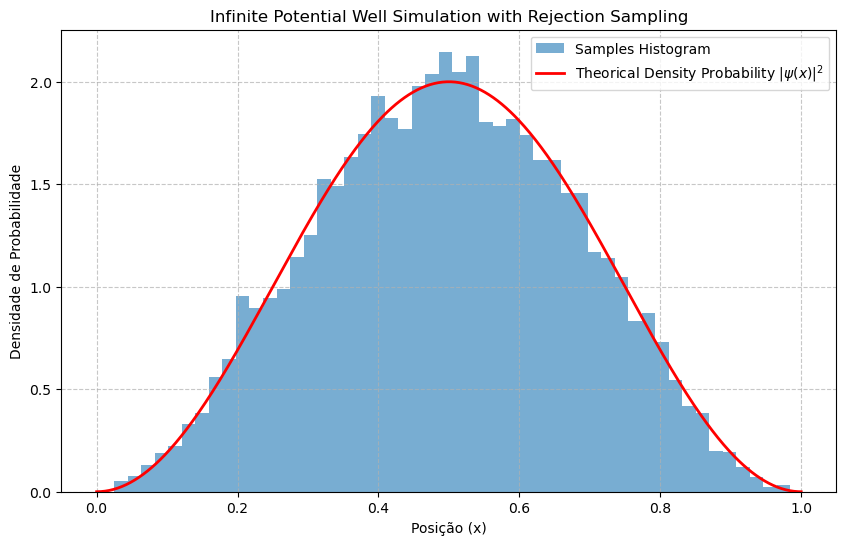

In [2]:
def psi_ground(x, L=1.0):
    """Função de onda do estado fundamental para o poço infinito."""
    return np.sqrt(2 / L) * np.sin(np.pi * x / L)

def p_density(x, L=1.0):
    """Densidade de probabilidade para o poço infinito."""
    return psi_ground(x, L)**2

def rejection_sample_positions(n_samples=2000, L=1.0):
    samples = []
    max_density = 2 / L
    plt.figure(figsize=(10, 6))
    while len(samples) < n_samples:
        x = np.random.uniform(0, L)
        u = np.random.uniform(0, max_density)
        if u < p_density(x, L):
            plt.plot(x,u, "x", color="blue")
            samples.append(x)
        else:
            plt.plot(x,u, "x", color="red")


    return np.array(samples)

def metropolis_hastings(n_samples=2000, L=1.0, sigma=0.1):
    samples = []
    x = np.random.uniform(0,L)
    accepted = 0

    while len(samples) < n_samples:
        x_proposal = x + np.random.normal(0, sigma)

        if x_proposal < 0 or x_proposal > L:
            samples.append(x)   
            continue
        
        p_current = p_density(x, L)
        p_proposal = p_density(x_proposal, L) ##UTILIZAMOS A MESMA FUNÇÃO DE DENSIDADE!
        accep_ratio = p_proposal / p_current #Se a densidade de probabilidade do novo x for maior que a do atual a razão sempre será > 1! 2/1 = 2! Caso contrário, rejeitamos x com uma probabilidade da razão pois tem menos chance de ocorrer.

        u = np.random.uniform(0,1)

        if u < min(1,   accep_ratio): #Se nossa proposta tiver densidade melhor, então o min será 1 e u < 1 sempre será verdade! Caso a proposta tiver densidade menor, ainda aceitamos ela, porém com uma probabilidade que depende de um número aleatório de 0 -1 (Acaso)!
            x = x_proposal
            accepted += 1
        samples.append(x)

    return np.array(samples)

# Geração de amostras para o poço infinito
n_samples = 10000
L_val = 1.0
samples_infinite = rejection_sample_positions(n_samples, L=L_val)

# # Plotagem para o poço infinito (com histograma e função de onda teórica)
plt.figure(figsize=(10, 6))
plt.hist(samples_infinite, bins=50, density=True, alpha=0.6, label='Samples Histogram')
x_plot = np.linspace(0, L_val, 500)
plt.plot(x_plot, p_density(x_plot, L_val), color='red', linewidth=2, label='Theorical Density Probability $|\psi(x)|^2$')
plt.title('Infinite Potential Well Simulation with Rejection Sampling')
plt.xlabel('Posição (x)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

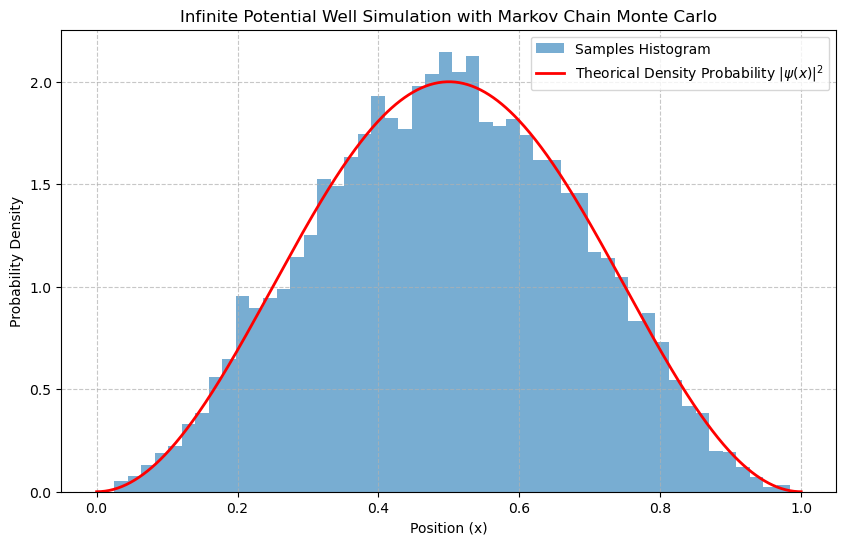

In [6]:
n_samples = 20000
L_val = 1.0
samples_infinite_mcmc = metropolis_hastings(n_samples, L=L_val)

plt.figure(figsize=(10, 6))
plt.hist(samples_infinite, bins=50, density=True, alpha=0.6, label='Samples Histogram')
x_plot = np.linspace(0, L_val, 500)
plt.plot(x_plot, p_density(x_plot, L_val), color='red', linewidth=2, label='Theorical Density Probability $|\psi(x)|^2$')
plt.title('Infinite Potential Well Simulation with Markov Chain Monte Carlo')
plt.xlabel('Position (x)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

VAE'S Inference


Iniciando treinamento do VAE para reconstruir Psi(x)...
VAE Epoch 0/500, Total Loss: 0.00033498, Recon Psi Loss: 0.00033473, KL Loss: 0.00024874
VAE Epoch 50/500, Total Loss: 0.00000588, Recon Psi Loss: 0.00000126, KL Loss: 0.00462084
VAE Epoch 100/500, Total Loss: 0.00000534, Recon Psi Loss: 0.00000074, KL Loss: 0.00459280
VAE Epoch 150/500, Total Loss: 0.00000525, Recon Psi Loss: 0.00000076, KL Loss: 0.00448962
VAE Epoch 200/500, Total Loss: 0.00000531, Recon Psi Loss: 0.00000071, KL Loss: 0.00459786
VAE Epoch 250/500, Total Loss: 0.00000535, Recon Psi Loss: 0.00000036, KL Loss: 0.00499100
VAE Epoch 300/500, Total Loss: 0.00000568, Recon Psi Loss: 0.00000070, KL Loss: 0.00498368
VAE Epoch 350/500, Total Loss: 0.00000528, Recon Psi Loss: 0.00000108, KL Loss: 0.00419544
VAE Epoch 400/500, Total Loss: 0.00000585, Recon Psi Loss: 0.00000130, KL Loss: 0.00455003
VAE Epoch 450/500, Total Loss: 0.00000493, Recon Psi Loss: 0.00000084, KL Loss: 0.00409696
Treinamento do VAE concluído.


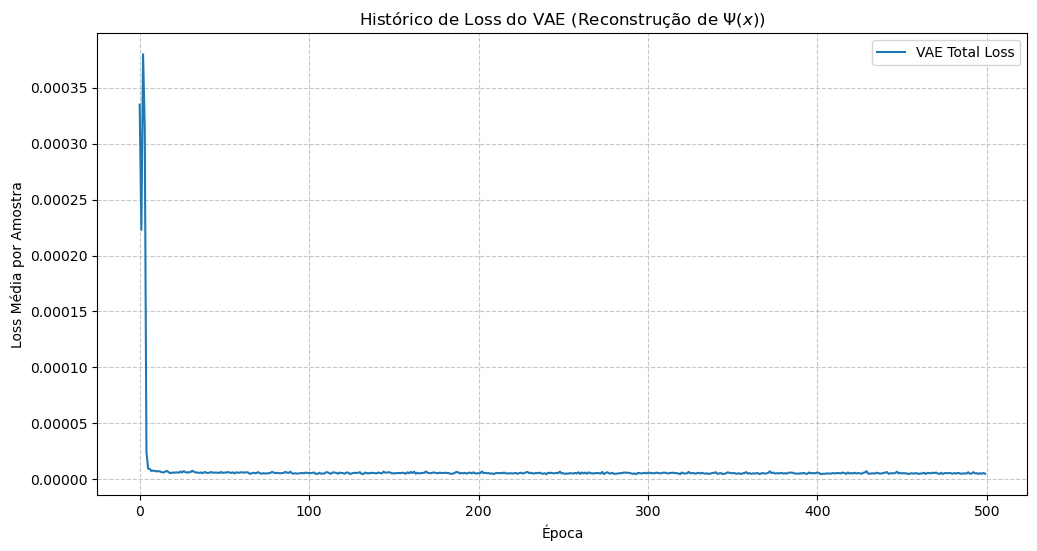

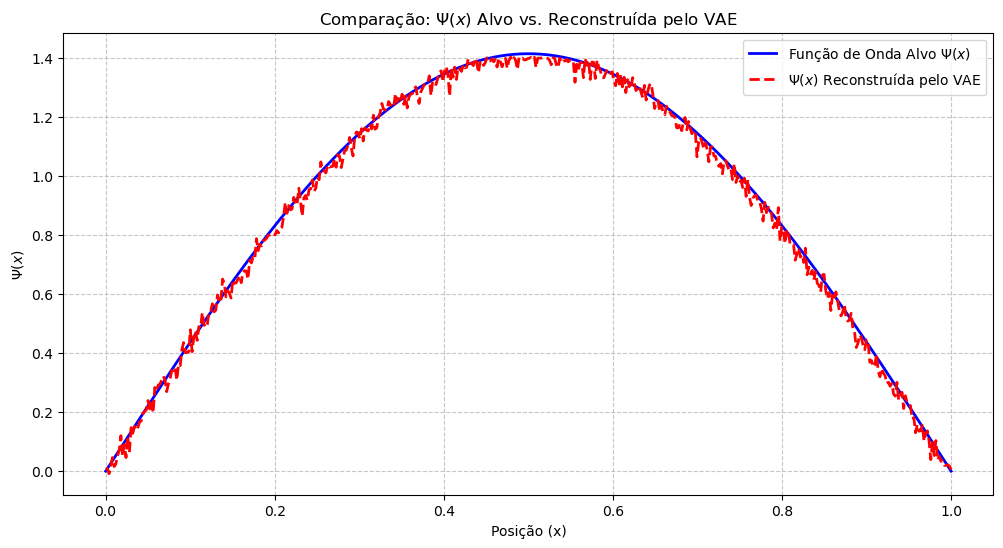

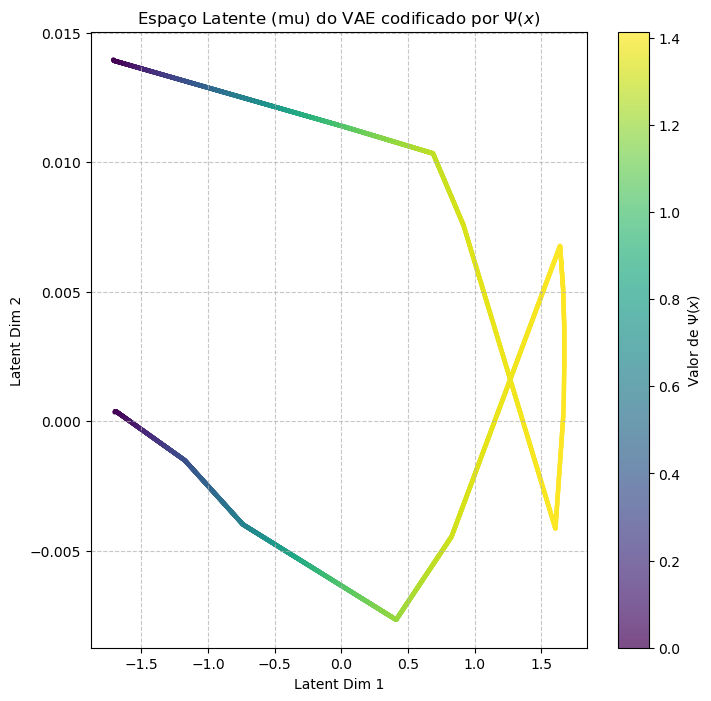

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# --- 3. DECODER ---
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_psi_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc_psi_out = nn.Linear(64, output_psi_dim) # Saída é o valor de Psi(x)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        psi_reconstructed = self.fc_psi_out(h)
        return psi_reconstructed

# --- 4. CLASSE VAE ---
class VAE(nn.Module):
    def __init__(self, input_x_dim, latent_dim, output_psi_dim):
        super().__init__()
        self.encoder = Encoder(input_x_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_psi_dim)

    def forward(self, x):
        # x_original é a entrada para o encoder
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        # O decoder reconstrói Psi(x) a partir de z
        psi_reconstructed = self.decoder(z)
        return psi_reconstructed, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Amostra de uma distribuição normal padrão
        return mu + eps * std

def vae_loss_function(psi_reconstructed, psi_original, mu, logvar, beta=1.0):
    reconstruction_loss_psi = F.mse_loss(psi_reconstructed, psi_original, reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss_psi + beta * kl_divergence
    return total_loss, reconstruction_loss_psi, kl_divergence


input_x_dim = 1 
latent_dim = 2 
output_psi_dim = 1 

vae_model = VAE(input_x_dim, latent_dim, output_psi_dim)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

num_data_samples = 10000 
L_val = 1.0 
x_data = torch.linspace(0, L_val, num_data_samples).view(-1, 1)


with torch.no_grad():
    psi_data = psi_ground(x_data, L=L_val)


num_epochs_vae = 500
batch_size = 128

vae_loss_history = []

print("\nIniciando treinamento do VAE para reconstruir Psi(x)...")
for epoch in range(num_epochs_vae):
    indices = torch.randperm(num_data_samples)
    for i in range(0, num_data_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        x_batch = x_data[batch_indices]
        psi_batch = psi_data[batch_indices]

        vae_optimizer.zero_grad()

        psi_reconstructed, mu, logvar = vae_model(x_batch)
        
        total_loss, recon_psi_loss, kl_loss = vae_loss_function(
            psi_reconstructed, psi_batch, mu, logvar, beta=0.001
        )

        total_loss.backward()
        vae_optimizer.step()

    vae_loss_history.append(total_loss.item() / num_data_samples) # Média da loss por amostra

    if epoch % 50 == 0:
        print(f"VAE Epoch {epoch}/{num_epochs_vae}, Total Loss: {total_loss.item() / num_data_samples:.8f}, "
              f"Recon Psi Loss: {recon_psi_loss.item() / num_data_samples:.8f}, "
              f"KL Loss: {kl_loss.item() / num_data_samples:.8f}")

print("Treinamento do VAE concluído.")


plt.figure(figsize=(12, 6))
plt.plot(vae_loss_history, label='VAE Total Loss')
plt.title('Histórico de Loss do VAE (Reconstrução de $\Psi(x)$)')
plt.xlabel('Época')
plt.ylabel('Loss Média por Amostra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))


x_plot_range = torch.linspace(0, L_val, 500).view(-1, 1)
psi_true_plot = psi_ground(x_plot_range, L=L_val).flatten().cpu().numpy()
plt.plot(x_plot_range.cpu().numpy(), psi_true_plot, color='blue', linewidth=2, label='Função de Onda Alvo $\Psi(x)$')


vae_model.eval() 
with torch.no_grad():

    psi_reconstructed_from_vae, _, _ = vae_model(x_plot_range)
    psi_reconstructed_from_vae = psi_reconstructed_from_vae.flatten().cpu().numpy()

plt.plot(x_plot_range.cpu().numpy(), psi_reconstructed_from_vae, color='red', linestyle='--', linewidth=2, label='$\Psi(x)$ Reconstruída pelo VAE')

plt.title('Comparação: $\Psi(x)$ Alvo vs. Reconstruída pelo VAE')
plt.xlabel('Posição (x)')
plt.ylabel('$\Psi(x)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

if latent_dim == 2:
    vae_model.eval()
    with torch.no_grad():
        mu_encoded, logvar_encoded = vae_model.encoder(x_data)
    mu_encoded = mu_encoded.cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(mu_encoded[:, 0], mu_encoded[:, 1], c=psi_data.flatten().cpu().numpy(), cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(label='Valor de $\Psi(x)$')
    plt.title('Espaço Latente (mu) do VAE codificado por $\Psi(x)$')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


#### Finite Potential Well VMC

Starting training for finite well: L=1.0, V0=10
NN hidden size: 64, LR: 0.001, Epochs: 500
MCMC samples: 5000, MCMC sigma: 0.3

Epoch 50/500 - Loss: 3.010795, MovAvg Loss: 3.095915 (Best: 2.986836), Alpha: 1.1377, MCMC Acc: 0.443
Epoch 100/500 - Loss: 3.123311, MovAvg Loss: 3.092942 (Best: 2.986836), Alpha: 1.1346, MCMC Acc: 0.448
Epoch 150/500 - Loss: 2.889669, MovAvg Loss: 3.021424 (Best: 2.986836), Alpha: 1.1335, MCMC Acc: 0.452
Epoch 200/500 - Loss: 3.287083, MovAvg Loss: 3.291307 (Best: 2.986836), Alpha: 1.1367, MCMC Acc: 0.439
Epoch 250/500 - Loss: 2.924554, MovAvg Loss: 3.152862 (Best: 2.986836), Alpha: 1.1414, MCMC Acc: 0.435
Epoch 300/500 - Loss: 3.183373, MovAvg Loss: 3.065215 (Best: 2.986836), Alpha: 1.1443, MCMC Acc: 0.440
Epoch 350/500 - Loss: 3.221723, MovAvg Loss: 3.194317 (Best: 2.986836), Alpha: 1.1400, MCMC Acc: 0.581
Epoch 400/500 - Loss: 3.246406, MovAvg Loss: 3.128347 (Best: 2.971275), Alpha: 1.1324, MCMC Acc: 0.619
Epoch 450/500 - Loss: 3.294638, MovAvg Loss: 3.11

<Figure size 1200x1000 with 0 Axes>

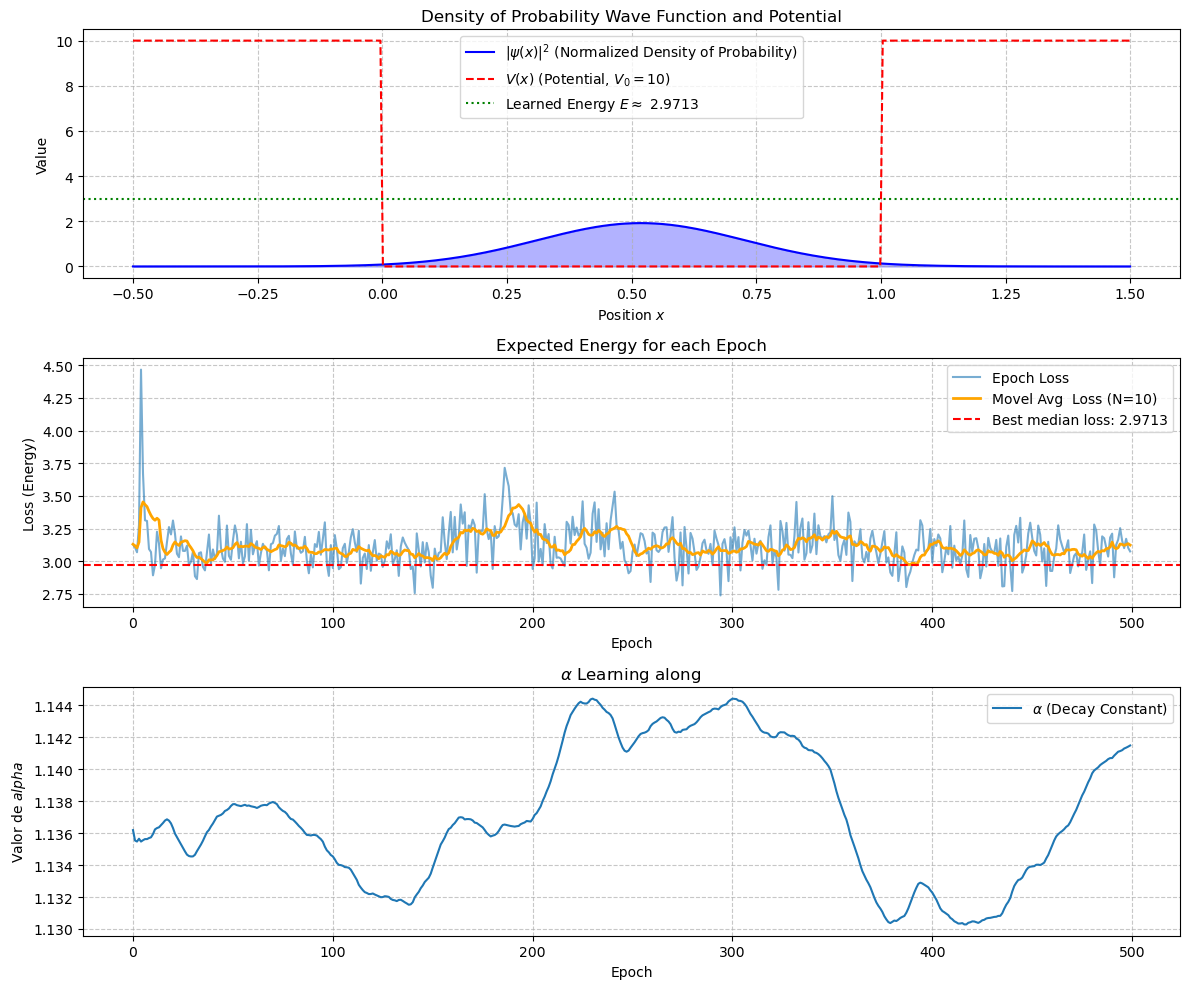


To confirm tunneling, observe if |psi(x)|^2 is non-zero outside the classical well boundaries (0 to 1.0) in the first plot.
The learned energy E should be less than V0 (10). Current E ~ 2.9713
Condition E < V0 is met, consistent with a bound state showing tunneling.


In [ ]:

torch.manual_seed(0)
np.random.seed(0)


def V(x, L=1.0, V0=10.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    potential = torch.zeros_like(x)
    outside_well = (x < 0) | (x > L)
    potential[outside_well] = V0
    return potential


class WaveFunction(nn.Module):
    def __init__(self, hidden_size=64, L=1.0, well_type="finite"): 
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1) 

        self.L = L
        self.well_type = well_type
        self.raw_alpha = nn.Parameter(torch.tensor(0.75, dtype=torch.float32))

    def forward(self, x):
        
        h = F.tanh(self.fc1(x)) 
        h = F.tanh(self.fc2(h))
        nn_output = self.fc3(h) 

        if self.well_type == "infinite":
            boundary_factor = x * (self.L - x)
            return nn_output * boundary_factor
        else:
            alpha = F.softplus(self.raw_alpha) * 5.0 
            x_centered_squared = (x - (self.L / 2))**2
            decay_factor_gaussian = torch.exp(-alpha * x_centered_squared)
            return nn_output * decay_factor_gaussian

def metropolis_hastings_vmc(wave_function_model, n_samples=2000, L=1.0, sigma=0.2, well_type="finite", initial_x=None):
    samples = []
    
    if initial_x is None:
        x = torch.rand(1, 1) * L 
    else:
        x = initial_x.clone().view(1,1)

    accepted_count = 0
    
    total_steps = n_samples 

    for _ in range(total_steps):
      
        x_proposal = x + sigma * torch.randn_like(x)

        if well_type == "infinite":
            if x_proposal < 0 or x_proposal > L:
                samples.append(x.detach().clone()) 
                continue 
        
  
        psi_current = wave_function_model(x)
        psi_proposal = wave_function_model(x_proposal)
      
        eps_prob = 1e-12 
        prob_current = psi_current**2 + eps_prob
        prob_proposal = psi_proposal**2 + eps_prob

 
        acceptance_ratio = prob_proposal / prob_current


        if torch.rand(1).item() < acceptance_ratio.item():
            x = x_proposal
            accepted_count += 1
        
        samples.append(x.detach().clone()) 

    acceptance_rate = accepted_count / total_steps
    return torch.stack(samples).view(-1, 1), acceptance_rate


def local_energy_finite_well(samples, network_model, L=1.0, V0=10.0, hbar_m_factor=0.5):

    samples.requires_grad_(True) 
    psi = network_model(samples)
    dpsi_dx = torch.autograd.grad(psi, samples, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, samples, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    samples.requires_grad_(False) 
    epsilon_psi = 1e-9 
    psi_denom = psi + torch.copysign(torch.tensor(epsilon_psi), psi)
    psi_denom[torch.abs(psi_denom) < epsilon_psi] = epsilon_psi 

    kinetic_energy = -hbar_m_factor * (d2psi_dx2 / psi_denom)
    
    
    potential_energy = V(samples, L=L, V0=V0)
    
    return kinetic_energy + potential_energy


def loss_fn(local_energies):
    return local_energies.mean()


# --- Main Training Loop ---
L_well = 1.
V0_barrier = 10
hidden_layer_size = 64 
learning_rate = 1e-3 
num_epochs = 500    
n_mc_samples = 5000  
mcmc_sigma = 0.3   
burn_in_ratio = 0.2  

# Initialize the model and optimizer
model = WaveFunction(hidden_size=hidden_layer_size, L=L_well, well_type="finite")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_loss_val = float('inf')
loss_history_N = 10 # For moving average
epoch_loss_history = []
moving_avg_loss_history = []
kappa_history = []

print(f"Starting training for finite well: L={L_well}, V0={V0_barrier}")
print(f"NN hidden size: {hidden_layer_size}, LR: {learning_rate}, Epochs: {num_epochs}")
print(f"MCMC samples: {n_mc_samples}, MCMC sigma: {mcmc_sigma}\n")


mcmc_initial_x = None 

for epoch in range(num_epochs):
    optimizer.zero_grad()
 

    raw_samples, acceptance_rate = metropolis_hastings_vmc(
        model, 
        n_samples=n_mc_samples, 
        L=L_well, 
        sigma=mcmc_sigma, 
        well_type="finite",
        initial_x=mcmc_initial_x 
    )
    

    num_burn_in = int(burn_in_ratio * len(raw_samples))
    effective_samples = raw_samples[num_burn_in:]

    local_energies_at_samples = local_energy_finite_well(
        effective_samples, model, L=L_well, V0=V0_barrier
    )

    current_loss = loss_fn(local_energies_at_samples)
    current_loss.backward()

    optimizer.step()
    
    loss_val = current_loss.item()
    epoch_loss_history.append(loss_val)
    
  
    if len(epoch_loss_history) > loss_history_N:
        current_moving_avg = sum(epoch_loss_history[-loss_history_N:]) / loss_history_N
    else:
        current_moving_avg = sum(epoch_loss_history) / len(epoch_loss_history)
    moving_avg_loss_history.append(current_moving_avg)

    current_kappa_val = F.softplus(model.raw_alpha).item()
    kappa_history.append(current_kappa_val)

    if current_moving_avg < best_loss_val : 
        best_loss_val = current_moving_avg
        torch.save(model.state_dict(), 'best_finite_well_model.pt')
        

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_val:.6f}, MovAvg Loss: {current_moving_avg:.6f} (Best: {best_loss_val:.6f}), Alpha: {current_kappa_val:.4f}, MCMC Acc: {acceptance_rate:.3f}")
        
    if epoch < 300:
        mcmc_sigma = 0.5
    elif epoch < 600:
        mcmc_sigma = 0.3
    else:
        mcmc_sigma = 0.2

print("\nTraining completed.")
print(f"Best Moving Average Loss achieved: {best_loss_val:.6f}")
final_kappa = F.softplus(model.raw_alpha).item()
print(f"Final Kappa: {final_kappa:.4f}")



print("\nPlotting results...")


best_model = WaveFunction(hidden_size=hidden_layer_size, L=L_well, well_type="finite")
try:
    best_model.load_state_dict(torch.load('best_finite_well_model.pt'))
    print("Successfully loaded 'best_finite_well_model.pt'")
except FileNotFoundError:
    print("Warning: 'best_finite_well_model.pt' not found. Plotting with the last model state.")
    best_model = model 
best_model.eval() 


x_plot_min = -L_well * 0.5 
x_plot_max = L_well * 1.5
x_plot_points = 400
x_vals_plot = torch.linspace(x_plot_min, x_plot_max, x_plot_points).view(-1, 1)


potential_vals_plot = V(x_vals_plot, L=L_well, V0=V0_barrier)
with torch.no_grad(): 
    psi_vals_plot = best_model(x_vals_plot)
prob_density_unnormalized_plot = psi_vals_plot**2



plt.figure(figsize=(12, 10))


epsilon_norm = 1e-12
norm_constant = torch.trapz(prob_density_unnormalized_plot.squeeze(), x_vals_plot.squeeze())
if torch.abs(norm_constant) < epsilon_norm:
    print(f"Warning! Epsilon is small ({norm_constant.item()}). The plot will be affected.")
    prob_density_normalized_plot = prob_density_unnormalized_plot
else:
    prob_density_normalized_plot = prob_density_unnormalized_plot / norm_constant 

print(f"Normalized cons|psi(x)|^2: {norm_constant.item():.4f}")


plt.figure(figsize=(12, 10))





plt.subplot(3, 1, 1)
plt.plot(x_vals_plot.numpy(), prob_density_normalized_plot.numpy(), label='$|\psi(x)|^2$ (Normalized Density of Probability)', color='blue')
plt.plot(x_vals_plot.numpy(), potential_vals_plot.numpy(), label=f'$V(x)$ (Potential, $V_0=${V0_barrier})', color='red', linestyle='--')

plt.axhline(y=best_loss_val, color='green', linestyle=':', label=f'Learned Energy $E \\approx$ {best_loss_val:.4f}')
plt.title('Density of Probability Wave Function and Potential')
plt.xlabel('Position $x$')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


plt.fill_between(x_vals_plot.numpy().squeeze(), prob_density_normalized_plot.numpy().squeeze(), alpha=0.3, color='blue')


plt.subplot(3, 1, 2)
plt.plot(epoch_loss_history, label='Epoch Loss', alpha=0.6)
plt.plot(moving_avg_loss_history, label='Movel Avg  Loss (N=10)', color='orange', linewidth=2)
plt.axhline(y=best_loss_val, color='red', linestyle='--', label=f'Best median loss: {best_loss_val:.4f}')
plt.title('Expected Energy for each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Energy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('linear')


plt.subplot(3, 1, 3)
plt.plot(kappa_history, label='$\\alpha$ (Decay Constant)')
plt.title('$\\alpha$ Learning along ')
plt.xlabel('Epoch')
plt.ylabel('Valor de $alpha$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nTo confirm tunneling, observe if |psi(x)|^2 is non-zero outside the classical well boundaries (0 to {L_well}) in the first plot.")
print(f"The learned energy E should be less than V0 ({V0_barrier}). Current E ~ {best_loss_val:.4f}")
if best_loss_val < V0_barrier:
    print("Condition E < V0 is met, consistent with a bound state showing tunneling.")
else:
    print("Warning: Learned energy E >= V0. This might indicate issues (e.g., not a bound state, or training problems).")

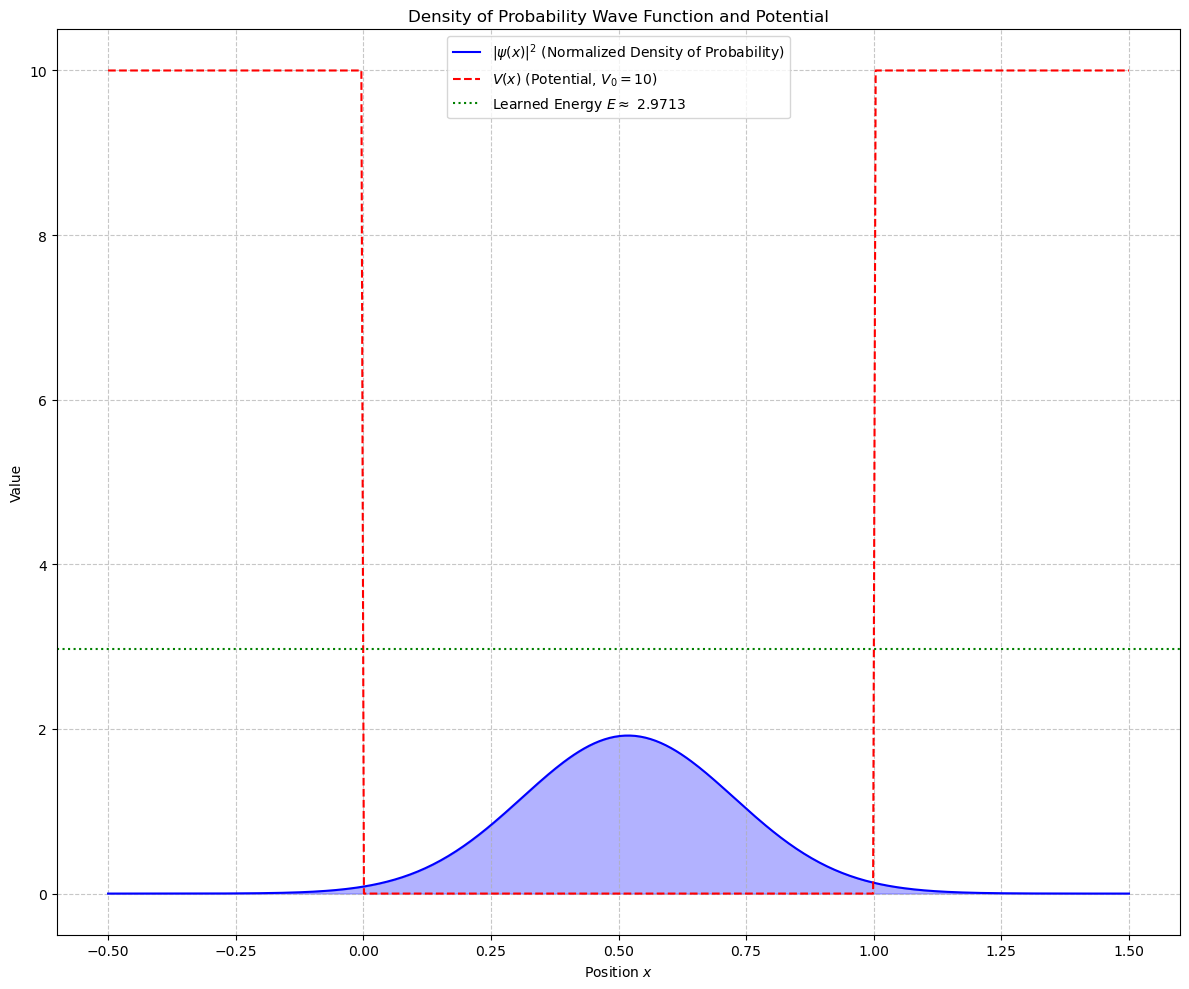


To confirm tunneling, observe if |psi(x)|^2 is non-zero outside the classical well boundaries (0 to 1.0) in the first plot.
The learned energy E should be less than V0 (10). Current E ~ 2.9713
Condition E < V0 is met, consistent with a bound state showing tunneling.


In [ ]:
plt.figure(figsize=(12, 10))


plt.plot(x_vals_plot.numpy(), prob_density_normalized_plot.numpy(), label='$|\psi(x)|^2$ (Normalized Density of Probability)', color='blue')
plt.plot(x_vals_plot.numpy(), potential_vals_plot.numpy(), label=f'$V(x)$ (Potential, $V_0=${V0_barrier})', color='red', linestyle='--')

plt.axhline(y=best_loss_val, color='green', linestyle=':', label=f'Learned Energy $E \\approx$ {best_loss_val:.4f}')
plt.title('Density of Probability Wave Function and Potential')
plt.xlabel('Position $x$')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


plt.fill_between(x_vals_plot.numpy().squeeze(), prob_density_normalized_plot.numpy().squeeze(), alpha=0.3, color='blue')



plt.tight_layout()
plt.show()

print(f"\nTo confirm tunneling, observe if |psi(x)|^2 is non-zero outside the classical well boundaries (0 to {L_well}) in the first plot.")
print(f"The learned energy E should be less than V0 ({V0_barrier}). Current E ~ {best_loss_val:.4f}")
if best_loss_val < V0_barrier:
    print("Condition E < V0 is met, consistent with a bound state showing tunneling.")
else:
    print("Warning: Learned energy E >= V0. This might indicate issues (e.g., not a bound state, or training problems).")

#### Infinite Well

In [ ]:
def VI(x, L=1, barrier=1e6):
    return torch.where((x >= 0) & (x <= L), torch.tensor(0.0), torch.tensor(barrier))
def local_energy_infinite_well(samples, network_model):
    samples.requires_grad_(True)
    psi = network_model(samples)
    dpsi_dx = torch.autograd.grad(psi, samples, grad_outputs=torch.ones_like(psi),create_graph=True,retain_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, samples, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    samples.requires_grad_(False) 
    eps = 1e-8
    return (-1/2) * (d2psi_dx2/psi + eps) + VI(samples)

def loss_energy(samples, network):
    esperada = local_energy_infinite_well(samples,network)
    return esperada.mean()
    
L_well = 1.
V0_barrier = 10
hidden_layer_size = 64 
learning_rate = 1e-3 
num_epochs = 100    
n_mc_samples = 2000  
mcmc_sigma = 0.3   
burn_in_ratio = 0.2  


model = WaveFunction(hidden_size=hidden_layer_size, L=L_well, well_type="infinite")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_loss_val = float('inf')
loss_history_N = 10 
epoch_loss_history = []
moving_avg_loss_history = []
kappa_history = []

print(f"Starting training for finite well: L={L_well}, V0={V0_barrier}")
print(f"NN hidden size: {hidden_layer_size}, LR: {learning_rate}, Epochs: {num_epochs}")
print(f"MCMC samples: {n_mc_samples}, MCMC sigma: {mcmc_sigma}\n")


mcmc_initial_x = None 

for epoch in range(num_epochs):
    optimizer.zero_grad()
 

    raw_samples, acceptance_rate = metropolis_hastings_vmc(
        model, 
        n_samples=n_mc_samples, 
        L=L_well, 
        sigma=mcmc_sigma, 
        well_type="infinite",
        initial_x=mcmc_initial_x 
    )
    

    num_burn_in = int(burn_in_ratio * len(raw_samples))
    effective_samples = raw_samples[num_burn_in:]

    current_loss = loss_energy(
        effective_samples, model
    )

    current_loss.backward()

    optimizer.step()
    
    loss_val = current_loss.item()
    epoch_loss_history.append(loss_val)
    
  
    if len(epoch_loss_history) > loss_history_N:
        current_moving_avg = sum(epoch_loss_history[-loss_history_N:]) / loss_history_N
    else:
        current_moving_avg = sum(epoch_loss_history) / len(epoch_loss_history)
    moving_avg_loss_history.append(current_moving_avg)

    current_kappa_val = F.softplus(model.raw_alpha).item()
    kappa_history.append(current_kappa_val)

    if current_moving_avg < best_loss_val : 
        best_loss_val = current_moving_avg
        torch.save(model.state_dict(), 'best_infinite_well_model.pt')
        

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_val:.6f}, MovAvg Loss: {current_moving_avg:.6f} (Best: {best_loss_val:.6f}), Kappa: {current_kappa_val:.4f}, MCMC Acc: {acceptance_rate:.3f}")

print("\nTraining completed.")
print(f"Best Moving Average Loss achieved: {best_loss_val:.6f}")
final_kappa = F.softplus(model.raw_alpha).item()
print(f"Final Kappa: {final_kappa:.4f}")






Starting training for finite well: L=1.0, V0=10
NN hidden size: 64, LR: 0.001, Epochs: 100
MCMC samples: 2000, MCMC sigma: 0.3

Epoch 50/100 - Loss: 4.952854, MovAvg Loss: 5.077890 (Best: 4.912134), Kappa: 1.1369, MCMC Acc: 0.591
Epoch 100/100 - Loss: 5.072988, MovAvg Loss: 5.046997 (Best: 4.912134), Kappa: 1.1369, MCMC Acc: 0.600

Training completed.
Best Moving Average Loss achieved: 4.912134
Final Kappa: 1.1369
